In [1]:
%cd /workspace
import os
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
import fiftyone as fo
from autodistill.utils import plot
import cv2
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/workspace


In [2]:
# check GPU availability
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


# <font color='orange'>Dataset loading</font>

In [3]:
dataset = fo.load_dataset("nuscenes")
print('Loaded dataset with %d samples' % len(dataset))

# Create filtered views for training and validation
train_view = dataset.match({"split": "train"})
val_view = dataset.match({"split": "validation"})

print('Loaded dataset with %d samples' % len(dataset))
print('%d train samples' % len(train_view))
print('%d validation samples' % len(val_view))

Loaded dataset with 33299 samples
Loaded dataset with 33299 samples
27430 train samples
5869 validation samples


In [4]:
session = fo.launch_app(dataset, auto=False)
# curl localhost:5151

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.


# <font color='cyan'>VLMs</font>

In [4]:
groundedSAM_model = GroundedSAM(
    ontology=CaptionOntology(
        {
            "person": "person",
            "ground vehicle car": "vehicle",

        }
    ),
    box_threshold=0.5, 
    text_threshold=0.5,
)

trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)


final text_encoder_type: bert-base-uncased


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

In [47]:
sample_path = val_view.take(1).first().filepath

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


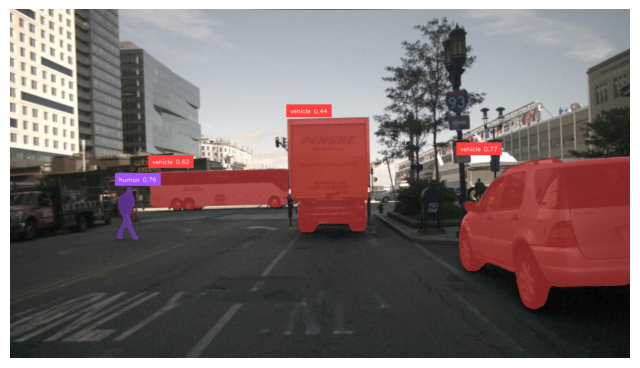

In [48]:
results_SAM = groundedSAM_model.predict(sample_path)
plot(
    image=cv2.imread(sample_path),
    classes=groundedSAM_model.ontology.classes(),
    detections=results_SAM
)

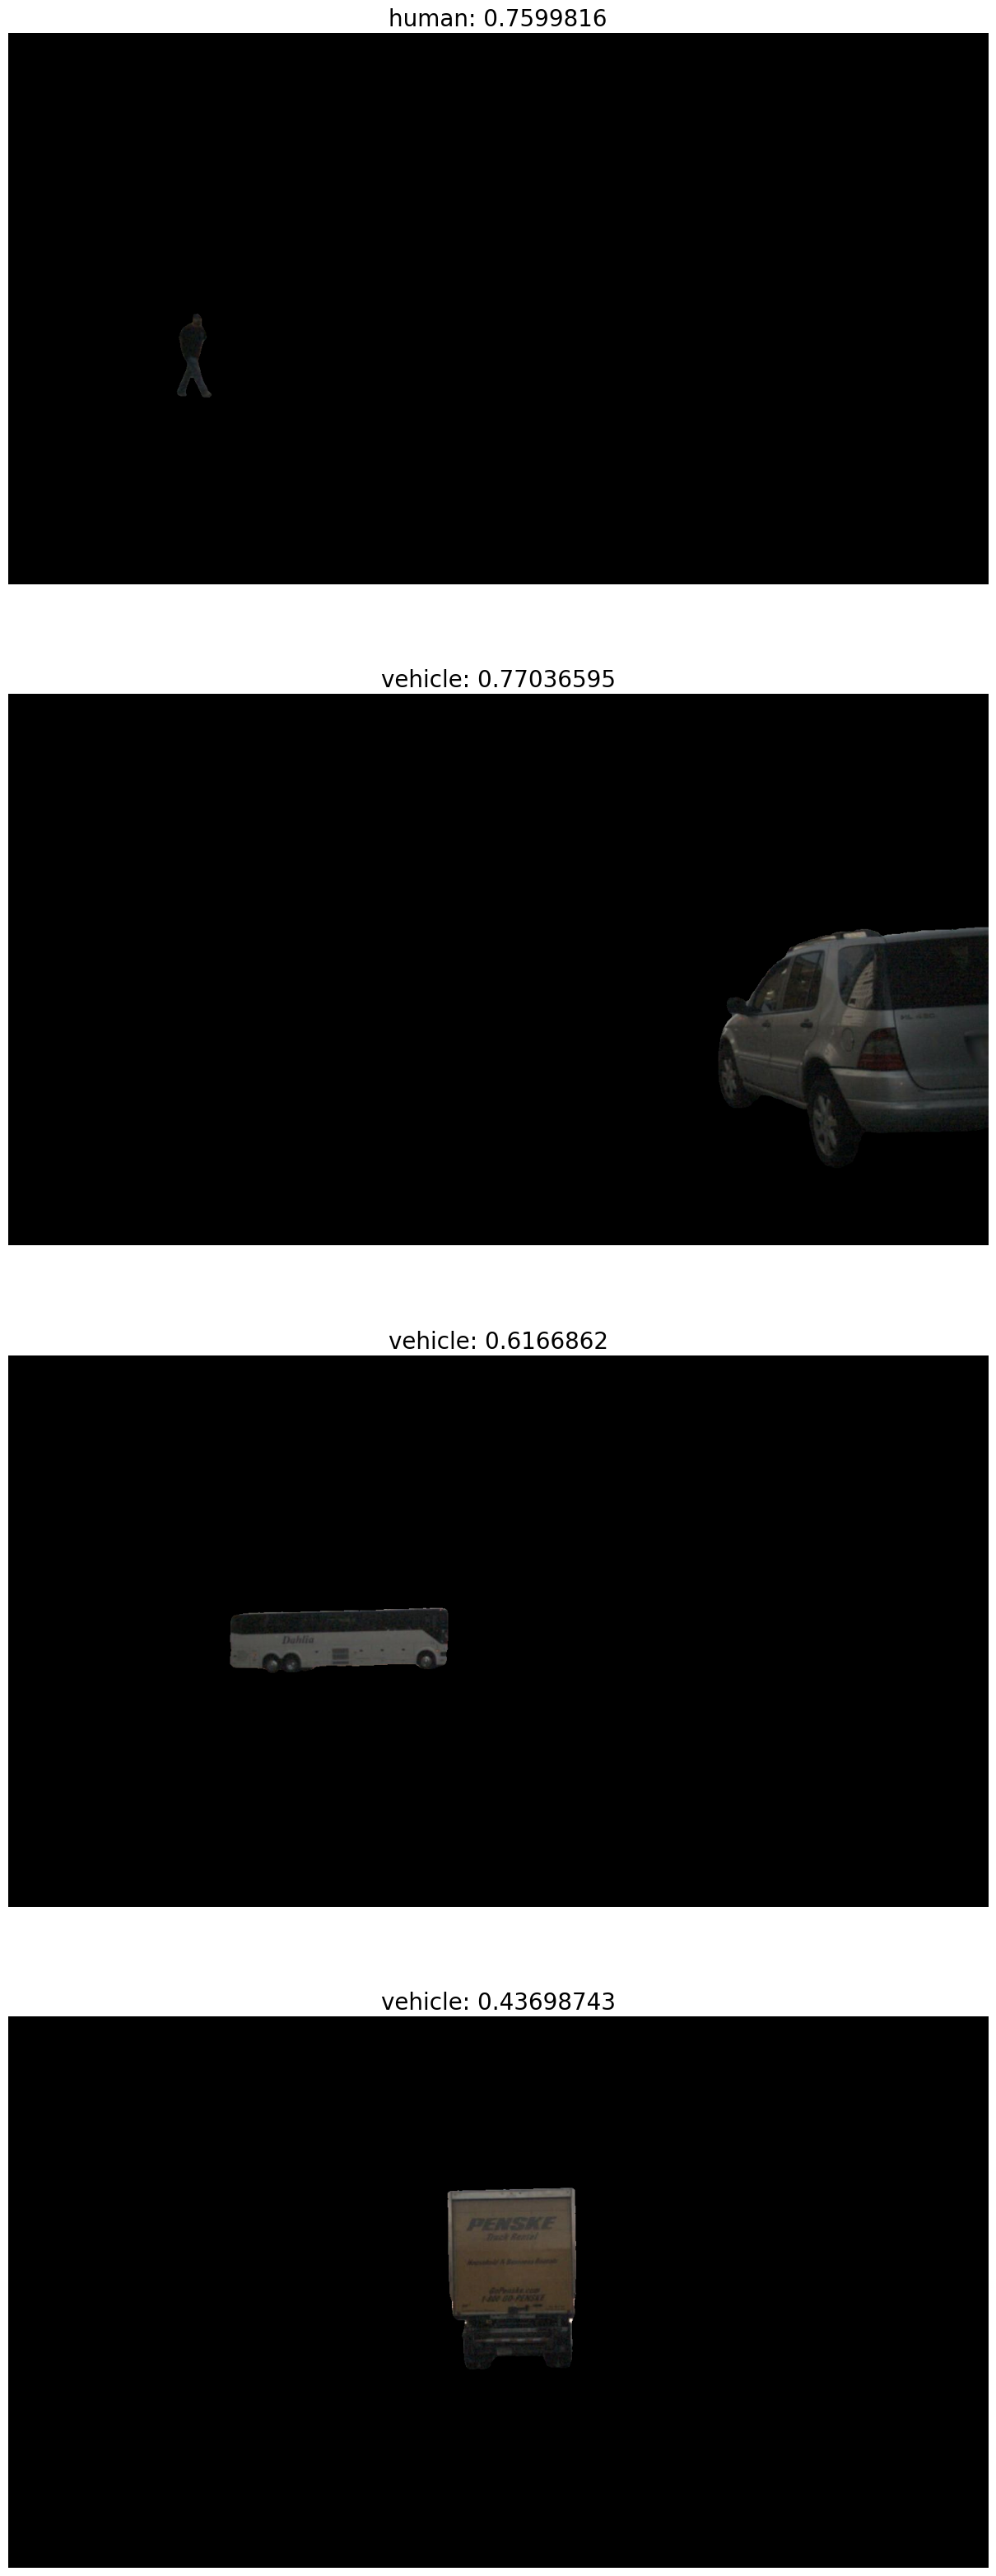

In [49]:
# plot all masks in a grid of images depending on the number of masks

image = cv2.imread(sample_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(len(results_SAM),1, figsize=(20, 40))
for i, mask in enumerate(results_SAM.mask):
    # mask the original image
    mask = np.array(mask)
    mask = mask.astype(np.uint8) * 255
    # crop the image based on the mask
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    axs[i].imshow(masked_image)
    # add the class name to the image
    axs[i].set_title(groundedSAM_model.ontology.classes()[results_SAM.class_id[i]] +": "+ str(results_SAM.confidence[i]), fontsize=20)
    axs[i].axis('off')
    
plt.show()


# <font color='purple'>Pseudo masks for all training data</font>

In [4]:
samples = train_view.select_group_slices(["CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"]).limit(60)

In [8]:
for sample in tqdm(samples, desc="Processing samples", unit="sample"):  
    sample = dataset[sample.id]
    results_SAM = groundedSAM_model.predict(sample.filepath)
    
    detections = []
    for i, mask in enumerate(results_SAM.mask):
        height, width = results_SAM.mask[i].shape
        bb = results_SAM.xyxy[i]
        # Convert to [x, y, width, height] format and normalize
        bb_normalized = [bb[0]/width, bb[1]/height, (bb[2]-bb[0])/width, (bb[3]-bb[1])/height]
        
        # crop mask to the bounding box
        bb = bb.astype(int)
        mask_cropped = mask[bb[1]:bb[3], bb[0]:bb[2]]
        
        
        detection = fo.Detection(mask=mask_cropped, 
                                bounding_box=bb_normalized,
                                confidence=round(results_SAM.confidence[i], 2),
                                label=groundedSAM_model.ontology.classes()[results_SAM.class_id[i]])
        detections.append(detection)
    
    sample["pseudo_masks"] = fo.Detections(detections=detections)
    sample.save()

Processing samples: 100%|██████████| 60/60 [02:30<00:00,  2.51s/sample]


In [5]:
session = fo.launch_app(samples, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.



Could not connect session, trying again in 10 seconds

